In [1]:

import pandas as pd
import numpy as np
import tensorflow as tf
import os
from tqdm import tqdm
from glob import glob
import gc
import cv2
import matplotlib.pyplot as plt
from sklearn.utils import shuffle
import math
import zipfile

In [2]:
train_csv = pd.read_csv('./data/train.csv')
test_csv = pd.read_csv('./data/test.csv')

In [3]:
train_csv.head()

,img_id,input_img,label_img
0,10000,train_input_10000.png,train_label_10000.png
1,10001,train_input_10001.png,train_label_10001.png
2,10002,train_input_10002.png,train_label_10002.png
3,10003,train_input_10003.png,train_label_10003.png
4,10004,train_input_10004.png,train_label_10004.png


In [13]:
train_all_input_files = 'D:/For Dacon/data/train_input_img/'+train_csv['input_img']
train_all_label_files = 'D:/For Dacon/data/train_label_img/'+train_csv['label_img']

In [14]:
len(train_all_input_files), len(train_all_label_files)

(622, 622)

In [15]:
train_all_input_files[0], train_all_label_files[0]

('D:/For Dacon/data/train_input_img/train_input_10000.png',
 'D:/For Dacon/data/train_label_img/train_label_10000.png')

In [16]:
train_input_files = train_all_input_files[60:].to_numpy()
train_label_files = train_all_label_files[60:].to_numpy()

val_input_files = train_all_input_files[:60].to_numpy()
val_label_files = train_all_label_files[:60].to_numpy()

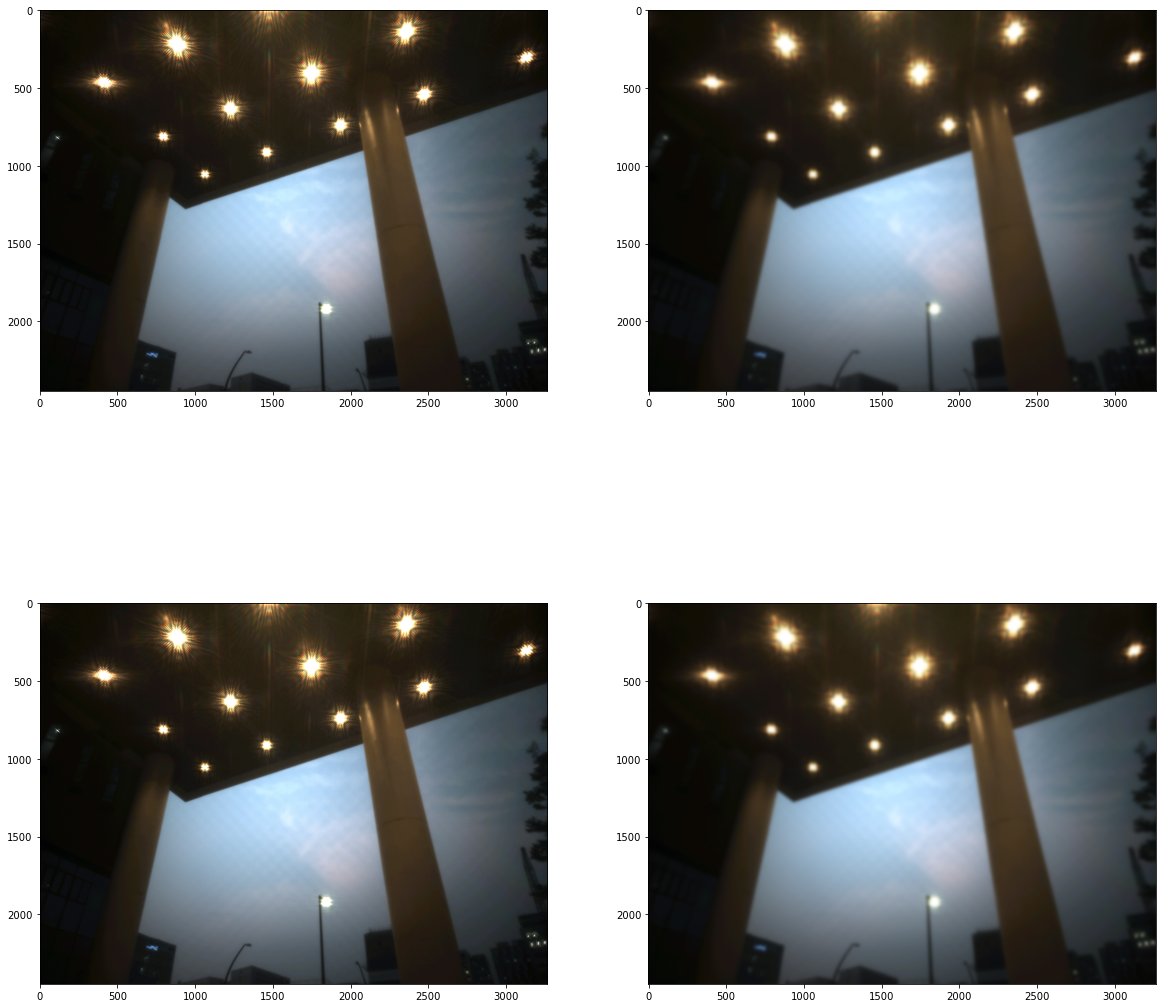

D:/For Dacon/data/train_input_img/train_input_10060.png D:/For Dacon/data/train_label_img/train_label_10060.png 



In [76]:
for input_path, label_path in zip(train_input_files, train_label_files):
    inp_img = cv2.imread(input_path)
    targ_img = cv2.imread(label_path)
    plt.figure(figsize=(20,20))
    
    inp_img = cv2.cvtColor(inp_img, cv2.COLOR_BGR2RGB)

    
    
    
    
    inp_img2 = cv2.GaussianBlur(inp_img, (55,55), 0)
    
    inp_img3 = cv2.bilateralFilter(inp_img, 5,15,15)
    
    inp_img4 = cv2.GaussianBlur(inp_img, (55,55), 0)
    inp_img4 = cv2.bilateralFilter(inp_img4, 5,150,150)
    
    plt.subplot(2,2,1)
    plt.imshow(inp_img)
    
    plt.subplot(2,2,2)
    plt.imshow(inp_img2)
    plt.subplot(2,2,3)
    plt.imshow(inp_img3)
    plt.subplot(2,2,4)
    plt.imshow(inp_img4)
    plt.show()
    
    print(input_path, label_path, '\n')
    break

In [43]:
BATCH_SIZE = 8
img_size = 256
#weights = None
weights = 'imagenet'
learning_rate = 1e-5
EPOCHS = 5
dropout_rate = 0.1

In [19]:
def blur_cut_img(img_path_list, save_path, stride):
    os.makedirs(f'{save_path}{img_size}', exist_ok=True)
    num = 0
    for path in tqdm(img_path_list):
        img = cv2.imread(path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = cv2.GaussianBlur(img, (55,55), 0)
        img = cv2.bilateralFilter(img, 5,150,150)
        for top in range(0, img.shape[0], stride):
            for left in range(0, img.shape[1], stride):
                piece = np.zeros([img_size, img_size, 3], np.uint8)
                temp = img[top:top+img_size, left:left+img_size, :]
                piece[:temp.shape[0], :temp.shape[1], :] = temp
                np.save(f'{save_path}{img_size}/{num}.npy', piece)
                num+=1

In [20]:
def blur_label_cut_img(img_path_list, save_path, stride):
    os.makedirs(f'{save_path}{img_size}', exist_ok=True)
    num = 0
    for path in tqdm(img_path_list):
        img = cv2.imread(path)
        for top in range(0, img.shape[0], stride):
            for left in range(0, img.shape[1], stride):
                piece = np.zeros([img_size, img_size, 3], np.uint8)
                temp = img[top:top+img_size, left:left+img_size, :]
                piece[:temp.shape[0], :temp.shape[1], :] = temp
                np.save(f'{save_path}{img_size}/{num}.npy', piece)
                num+=1

In [30]:
blur_cut_img(train_input_files, './data3/blur_train_input_img_', 128)

100%|████████████████████████████████████████████████████████████████████████████████| 562/562 [12:20<00:00,  1.32s/it]


In [23]:
blur_label_cut_img(train_label_files, './data3/blur_train_label_img_', 128)

100%|████████████████████████████████████████████████████████████████████████████████| 562/562 [11:11<00:00,  1.19s/it]


In [24]:
blur_cut_img(val_input_files, './data3/blur_val_input_img_', 128)

100%|██████████████████████████████████████████████████████████████████████████████████| 60/60 [02:13<00:00,  2.22s/it]


In [25]:
blur_label_cut_img(val_label_files, './data3/blur_val_label_img_', 128)

100%|██████████████████████████████████████████████████████████████████████████████████| 60/60 [02:16<00:00,  2.28s/it]


In [31]:
train_inp_files = glob(f'./data3/blur_train_input_img_{img_size}/*.npy')
train_targ_files = glob(f'./data3/blur_train_label_img_{img_size}/*.npy')

val_inp_files = glob(f'./data3/blur_val_input_img_{img_size}/*.npy')
val_targ_files = glob(f'./data3/blur_val_input_img_{img_size}/*.npy')

In [33]:
train_inp_files, train_targ_files = shuffle(train_inp_files, train_targ_files, random_state=42)

In [34]:
len(train_inp_files), len(val_inp_files), len(train_targ_files), len(val_targ_files), 

(155740, 31200, 155740, 31200)

In [44]:
def train_map_func(inp_path, targ_path):
    inp = np.load(inp_path)
    inp = inp.astype(np.float32)/255
    targ = np.load(targ_path)
    targ = targ.astype(np.float32)/255
    inp, targ = augmentation(inp, targ)
    
    return inp, targ

def val_map_func(inp_path, targ_path):
    inp = np.load(inp_path)
    inp = inp.astype(np.float32)/255
    targ = np.load(targ_path)
    targ = targ.astype(np.float32)/255
    return inp, targ

def augmentation(inp, targ):
    inp, targ = random_rot(inp, targ)
    inp, targ = random_flip(inp, targ)
    
    return inp, targ

def random_rot(inp, targ):
    k = np.random.randint(4)
    inp = np.rot90(inp, k)
    targ = np.rot90(targ, k)
    
    return inp, targ

def random_flip(inp, targ):
    f = np.random.randint(2)
    if f == 0:
        inp = np.fliplr(inp)
        targ = np.fliplr(targ)
        
    return inp, targ

In [45]:
train_dataset = tf.data.Dataset.from_tensor_slices((train_inp_files, train_targ_files))
train_dataset = train_dataset.map(lambda item1, item2: tf.numpy_function(train_map_func, [item1, item2], [tf.float32, tf.float32]), num_parallel_calls=tf.data.experimental.AUTOTUNE)
train_dataset = train_dataset.batch(BATCH_SIZE)
train_dataset = train_dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

val_dataset = tf.data.Dataset.from_tensor_slices((val_inp_files, val_targ_files))
val_dataset = val_dataset.map(lambda item1, item2: tf.numpy_function(val_map_func, [item1, item2], [tf.float32, tf.float32]), num_parallel_calls=tf.data.experimental.AUTOTUNE)
val_dataset = val_dataset.batch(BATCH_SIZE)
val_dataset = val_dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

In [46]:
next(iter(train_dataset))[0].shape, next(iter(train_dataset))[1].shape, next(iter(val_dataset))[0].shape, next(iter(val_dataset))[1].shape

(TensorShape([8, 256, 256, 3]),
 TensorShape([8, 256, 256, 3]),
 TensorShape([8, 256, 256, 3]),
 TensorShape([8, 256, 256, 3]))

In [47]:
def convolution_block(x, filters, size, strides=(1,1), padding='same', activation=True):
    x = tf.keras.layers.Conv2D(filters, size, strides=strides, padding=padding)(x)
    x = tf.keras.layers.BatchNormalization()(x)
    if activation == True:
        x = tf.keras.layers.LeakyReLU(alpha=0.1)(x)
    return x

def residual_block(blockInput, num_filters=16):
    x = tf.keras.layers.LeakyReLU(alpha=0.1)(blockInput)
    x = tf.keras.layers.BatchNormalization()(x)
    blockInput = tf.keras.layers.BatchNormalization()(blockInput)
    x = convolution_block(x, num_filters, (3,3) )
    x = convolution_block(x, num_filters, (3,3), activation=False)
    x = tf.keras.layers.Add()([x, blockInput])
    return x

In [48]:
def ResUNet101V2(input_shape=(None, None, 3), dropout_rate=0.1, start_neurons = 16):
    backbone = tf.keras.applications.ResNet101V2(weights=weights, include_top=False, input_shape=input_shape)
    input_layer = backbone.input
    
    conv4 = backbone.layers[122].output
    conv4 = tf.keras.layers.LeakyReLU(alpha=0.1)(conv4)
    pool4 = tf.keras.layers.MaxPooling2D((2, 2))(conv4)
    pool4 = tf.keras.layers.Dropout(dropout_rate)(pool4)
    
    convm = tf.keras.layers.Conv2D(start_neurons * 32, (3, 3), activation=None, padding="same")(pool4)
    convm = residual_block(convm,start_neurons * 32)
    convm = residual_block(convm,start_neurons * 32)
    convm = tf.keras.layers.LeakyReLU(alpha=0.1)(convm)
    
    deconv4 = tf.keras.layers.Conv2DTranspose(start_neurons * 16, (3, 3), strides=(2, 2), padding="same")(convm)
    uconv4 = tf.keras.layers.concatenate([deconv4, conv4])
    uconv4 = tf.keras.layers.Dropout(dropout_rate)(uconv4)
    
    uconv4 = tf.keras.layers.Conv2D(start_neurons * 16, (3, 3), activation=None, padding="same")(uconv4)
    uconv4 = residual_block(uconv4,start_neurons * 16)
    uconv4 = residual_block(uconv4,start_neurons * 16)
    uconv4 = tf.keras.layers.LeakyReLU(alpha=0.1)(uconv4)
    
    deconv3 = tf.keras.layers.Conv2DTranspose(start_neurons * 8, (3, 3), strides=(2, 2), padding="same")(uconv4)
    conv3 = backbone.layers[76].output
    uconv3 = tf.keras.layers.concatenate([deconv3, conv3])    
    uconv3 = tf.keras.layers.Dropout(dropout_rate)(uconv3)
    
    uconv3 = tf.keras.layers.Conv2D(start_neurons * 8, (3, 3), activation=None, padding="same")(uconv3)
    uconv3 = residual_block(uconv3,start_neurons * 8)
    uconv3 = residual_block(uconv3,start_neurons * 8)
    uconv3 = tf.keras.layers.LeakyReLU(alpha=0.1)(uconv3)

    deconv2 = tf.keras.layers.Conv2DTranspose(start_neurons * 4, (3, 3), strides=(2, 2), padding="same")(uconv3)
    conv2 = backbone.layers[30].output
    uconv2 = tf.keras.layers.concatenate([deconv2, conv2])
        
    uconv2 = tf.keras.layers.Dropout(0.1)(uconv2)
    uconv2 = tf.keras.layers.Conv2D(start_neurons * 4, (3, 3), activation=None, padding="same")(uconv2)
    uconv2 = residual_block(uconv2,start_neurons * 4)
    uconv2 = residual_block(uconv2,start_neurons * 4)
    uconv2 = tf.keras.layers.LeakyReLU(alpha=0.1)(uconv2)
    
    deconv1 = tf.keras.layers.Conv2DTranspose(start_neurons * 2, (3, 3), strides=(2, 2), padding="same")(uconv2)
    conv1 = backbone.layers[2].output
    uconv1 = tf.keras.layers.concatenate([deconv1, conv1])
    
    uconv1 = tf.keras.layers.Dropout(0.1)(uconv1)
    uconv1 = tf.keras.layers.Conv2D(start_neurons * 2, (3, 3), activation=None, padding="same")(uconv1)
    uconv1 = residual_block(uconv1,start_neurons * 2)
    uconv1 = residual_block(uconv1,start_neurons * 2)
    uconv1 = tf.keras.layers.LeakyReLU(alpha=0.1)(uconv1)
    
    uconv0 = tf.keras.layers.Conv2DTranspose(start_neurons * 1, (3, 3), strides=(2, 2), padding="same")(uconv1)   
    uconv0 = tf.keras.layers.Dropout(0.1)(uconv0)
    uconv0 = tf.keras.layers.Conv2D(start_neurons * 1, (3, 3), activation=None, padding="same")(uconv0)
    uconv0 = residual_block(uconv0,start_neurons * 1)
    uconv0 = residual_block(uconv0,start_neurons * 1)
    uconv0 = tf.keras.layers.LeakyReLU(alpha=0.1)(uconv0)
    
    uconv0 = tf.keras.layers.Dropout(dropout_rate/2)(uconv0)
    output_layer = tf.keras.layers.Conv2D(3, (1,1), padding="same", activation="sigmoid")(uconv0)    
    
    model = tf.keras.models.Model(input_layer, output_layer)

    return model

In [49]:
optimizer = tf.keras.optimizers.Adam(learning_rate)
model = ResUNet101V2(input_shape=(img_size, img_size, 3),dropout_rate=dropout_rate)
model.compile(loss='mae', optimizer=optimizer)

In [50]:
callbacks_list = [
    tf.keras.callbacks.ModelCheckpoint(
        filepath = 'models/baseline_model.h5',
        monitor='val_loss',
        save_best_only=True
    )
]

In [51]:
hist = model.fit(train_dataset, epochs=10, validation_data=val_dataset, callbacks=callbacks_list)

Epoch 1/10
19468/19468 [==============================] - 5528s 284ms/step - loss: 0.0659 - val_loss: 0.0524


D:\ANACONDA\lib\site-packages\tensorflow\python\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 2/10
19468/19468 [==============================] - 5089s 261ms/step - loss: 0.0362 - val_loss: 0.0504
Epoch 3/10
19468/19468 [==============================] - 5128s 263ms/step - loss: 0.0324 - val_loss: 0.0545
Epoch 4/10
19468/19468 [==============================] - 5139s 264ms/step - loss: 0.0300 - val_loss: 0.0497
Epoch 5/10
19468/19468 [==============================] - 5131s 263ms/step - loss: 0.0283 - val_loss: 0.0521
Epoch 6/10
19468/19468 [==============================] - 5183s 266ms/step - loss: 0.0270 - val_loss: 0.0493
Epoch 7/10
19468/19468 [==============================] - 5142s 264ms/step - loss: 0.0260 - val_loss: 0.0515
Epoch 8/10
19468/19468 [==============================] - 5253s 270ms/step - loss: 0.0251 - val_loss: 0.0461
Epoch 9/10
19468/19468 [==============================] - 5142s 264ms/step - loss: 0.0244 - val_loss: 0.0462
Epoch 10/10
19468/19468 [==============================] - 5152s 265ms/step - loss: 0.0238 - val_loss: 0.0481


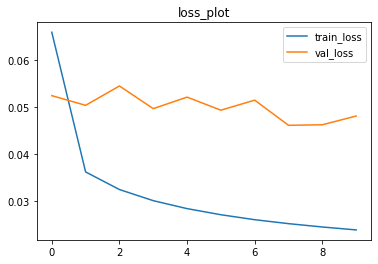

In [52]:
plt.plot(hist.history["loss"], label='train_loss')
plt.plot(hist.history["val_loss"], label='val_loss')
plt.title('loss_plot')
plt.legend()
plt.show()

In [53]:
model = tf.keras.models.load_model('models/baseline_model.h5')

In [54]:
def predict(img_paths, stride=32, batch_size=128):
    results = []
    for img_path in img_paths:
        img = cv2.imread(img_path)
        img = cv2.GaussianBlur(img, (55,55), 0)
        img = cv2.bilateralFilter(img, 5,15,15)
        img = img.astype(np.float32)/255
        crop = []
        position = []
        batch_count = 0

        result_img = np.zeros_like(img)
        voting_mask = np.zeros_like(img)

        for top in tqdm(range(0, img.shape[0], stride)):
            for left in range(0, img.shape[1], stride):
                piece = np.zeros([img_size, img_size, 3], np.float32)
                temp = img[top:top+img_size, left:left+img_size, :]
                piece[:temp.shape[0], :temp.shape[1], :] = temp
                crop.append(piece)
                position.append([top, left])
                batch_count += 1
                if batch_count == batch_size:
                    crop = np.array(crop)
                    pred = model(crop)*255
                    crop = []
                    batch_count = 0
                    for num, (t, l) in enumerate(position):
                        piece = pred[num]
                        h, w, c = result_img[t:t+img_size, l:l+img_size, :].shape
                        result_img[t:t+img_size, l:l+img_size, :] += piece[:h, :w]
                        voting_mask[t:t+img_size, l:l+img_size, :] += 1
                    position = []
        
        result_img = result_img/voting_mask
        result_img = result_img.astype(np.uint8)
        results.append(result_img)
        
    return results

In [55]:
def rmse_score(true, pred):
    score = math.sqrt(np.mean((true-pred)**2))
    return score

def psnr_score(true, pred, pixel_max):
    score = 20*np.log10(pixel_max/rmse_score(true, pred))
    return score

In [56]:
result = predict(val_input_files[:5], 32)

100%|██████████████████████████████████████████████████████████████████████████████████| 77/77 [01:13<00:00,  1.04it/s]


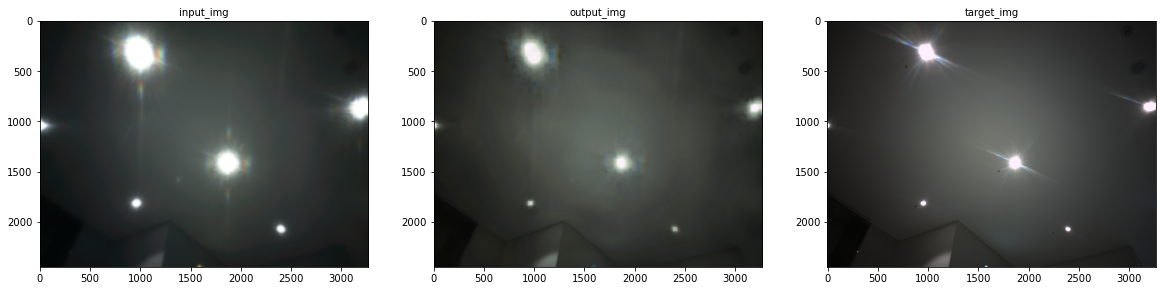

input PSNR : 21.555101548512322
output PSNR : 30.097140304944023 



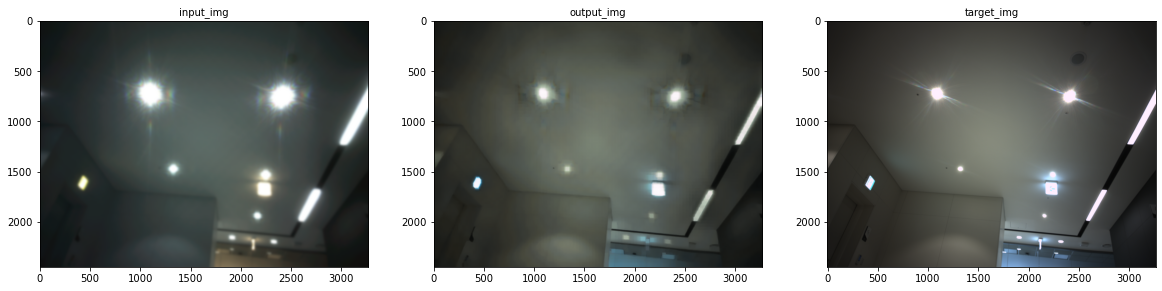

input PSNR : 20.570454204267193
output PSNR : 26.087782821917376 



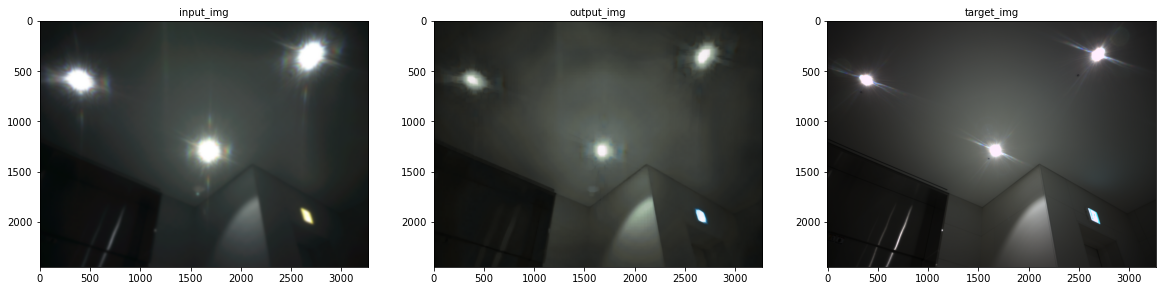

input PSNR : 21.87923281126764
output PSNR : 30.74136848570594 



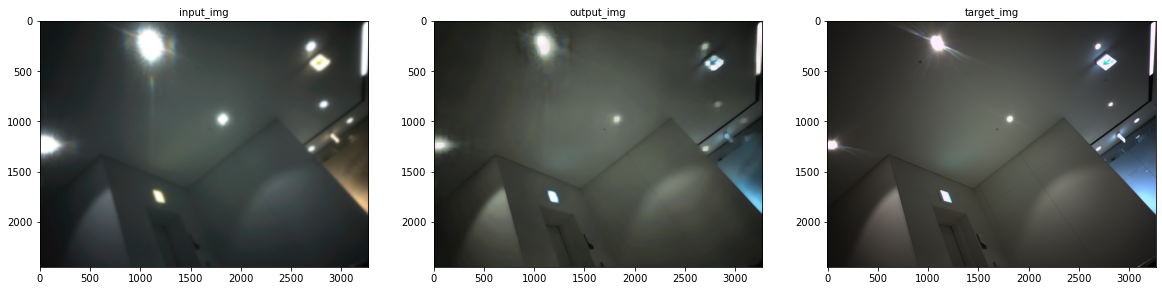

input PSNR : 20.485745916755484
output PSNR : 24.65234969118407 



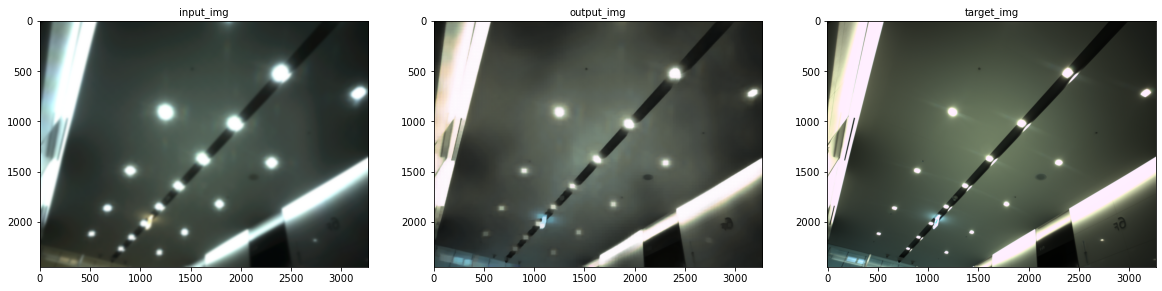

input PSNR : 20.545789142892023
output PSNR : 24.658154112165164 



In [103]:
kernel = np.ones((30,30),np.uint8)
for i, (input_path, label_path) in enumerate(zip(val_input_files[:5], val_label_files[:5])):
    input_img = cv2.imread(input_path)
    input_img = cv2.GaussianBlur(input_img, (55,55), 0)
    input_img = cv2.bilateralFilter(input_img, 5,15,15)

    targ_img = cv2.imread(label_path)
    targ_img = cv2.cvtColor(targ_img, cv2.COLOR_BGR2RGB)
    
    pred_img = result[i]
    pred_img = cv2.morphologyEx(pred_img, cv2.MORPH_OPEN, kernel)
    pred_img = cv2.cvtColor(pred_img, cv2.COLOR_BGR2RGB)
    
    
    plt.figure(figsize=(20,10))
    plt.subplot(1,3,1)
    plt.imshow(input_img)
    plt.title('input_img', fontsize=10)
    plt.subplot(1,3,2)
    plt.imshow(pred_img)
    plt.title('output_img', fontsize=10)
    plt.subplot(1,3,3)
    plt.imshow(targ_img)
    plt.title('target_img', fontsize=10)
    plt.show()
    print('input PSNR :', psnr_score(input_img.astype(float), targ_img.astype(float), 255))
    print('output PSNR :', psnr_score(result[i].astype(float), targ_img.astype(float), 255), '\n')

In [101]:
test_input_files = './data3/test_input_img/'+test_csv['input_img']

In [64]:
test_result = predict(test_input_files, 32)

100%|██████████████████████████████████████████████████████████████████████████████████| 77/77 [01:15<00:00,  1.02it/s]


In [102]:
for i, input_path in enumerate(test_input_files):
    input_img = cv2.imread(input_path)
    input_img = cv2.cvtColor(input_img, cv2.COLOR_BGR2RGB)
    
    pred_img = test_result[i]
    pred_img = cv2.cvtColor(pred_img, cv2.COLOR_BGR2RGB)
    
    plt.figure(figsize=(20,10))
    plt.subplot(1,2,1)
    plt.imshow(input_img)
    plt.title('input_img', fontsize=10)
    plt.subplot(1,2,2)
    plt.imshow(pred_img)
    plt.title('output_img', fontsize=10)
    plt.show()

error: OpenCV(4.5.3) C:\Users\runneradmin\AppData\Local\Temp\pip-req-build-q3d_8t8e\opencv\modules\imgproc\src\color.cpp:182: error: (-215:Assertion failed) !_src.empty() in function 'cv::cvtColor'


In [66]:
def make_submission(result):
    os.makedirs('submission2', exist_ok=True)
    os.chdir("./submission2/")
    sub_imgs = []
    for i, img in enumerate(result):
        path = f'test_{20000+i}.png'
        cv2.imwrite(path, img)
        sub_imgs.append(path)
    submission = zipfile.ZipFile("submission2.zip", 'w')
    for path in sub_imgs:
        submission.write(path)
    submission.close()

In [67]:
make_submission(test_result)